In [1]:
import tensorflow as tf

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

In [3]:
import preprocessing

In [5]:
resolution = 5
length = 3000
noterange = 64

train_images = preprocessing.loadData(songLen=length)
labels = np.zeros(len(train_images))

In [6]:
songLength = int(length / resolution)
midiNotes = noterange

In [7]:
train_images = train_images.reshape(train_images.shape[0], songLength, midiNotes, 1).astype('float32')
train_images = (train_images -0.5) * 2  # Normalize the images to [-1, 1]

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-05-20 14:22:03.815645: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
in_shape = [midiNotes, songLength, 1]

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()
    y = int(songLength/4)
    x = int(midiNotes/4)
    model.add(layers.Dense(x*y*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((y, x, 256)))
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, songLength/2, midiNotes/2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, songLength,midiNotes, 1)

    return model

(None, 600, 64, 1)


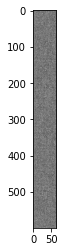

In [18]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [19]:
generated_image[0, :, :, 0][0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 4.9838844e-05, -5.1660673e-04,  1.5106095e-03, -8.3685358e-04,
       -5.9230038e-04, -9.6559565e-04, -3.9237589e-04,  3.9036752e-04,
        5.1881530e-04, -6.7058555e-04, -1.2038908e-03,  4.8150960e-04,
       -1.5266301e-03,  2.2182525e-03,  6.7348138e-04, -1.1331978e-03,
       -1.8471184e-03,  3.3402541e-03, -6.3963357e-04,  1.0213881e-03,
       -1.0210930e-03,  1.7418301e-03, -4.7503028e-04, -2.0401410e-03,
       -2.3413303e-03,  1.5004218e-03,  1.7318844e-03, -2.3531718e-03,
       -2.3719222e-04,  6.6702953e-04, -2.0644977e-05, -1.4550498e-03,
        5.2270887e-04,  5.9653365e-04,  6.0370116e-04, -1.3400603e-04,
       -8.8624982e-04,  1.9752390e-04, -1.1224633e-03, -2.7301500e-04,
       -4.1570512e-04,  9.0869871e-04,  1.5295472e-04, -9.9031429e-04,
       -5.9800979e-04,  8.1488595e-04, -1.7392723e-04,  6.5026898e-04,
       -1.2380227e-03,  7.3870906e-04,  4.4931853e-04, -4.5800759e-04,
       -2.9410940e-04,  2.1915

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[songLength, midiNotes, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00010155]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [ ]:
train(train_dataset, EPOCHS)

NameError: name 'train_dataset' is not defined

In [ ]:
tf.keras.models.save_model(generator, f"../models/gan_{EPOCHS}_generator.h5")
tf.keras.models.save_model(discriminator, f"../models/gan_{EPOCHS}_discriminator.h5")